In [1]:
from utils.binaries import *
from utils.plotting import *

18:51:20 (   +5.4s) [INFO   ] -- import logging
18:51:21 (  +364ms) [INFO   ] -- import numpy as np
18:51:21 (   +14ms) [INFO   ] -- import uncertainties
18:51:22 (   +1.3s) [INFO   ] -- import pandas as pd
18:51:22 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
18:51:22 (    +2ms) [INFO   ] -- import binaries.tools as tools
18:51:23 (   +1.5s) [INFO   ] -- import matplotlib.pyplot as plt
18:51:25 (   +1.8s) [INFO   ] -- import seaborn as so
18:51:25 (    +5ms) [INFO   ] -- import plotting.tools as plot
18:51:25 (   +78ms) [DEBUG  ] -- font size set to 9.5
18:51:25 (    +1ms) [DEBUG  ] -- label size set to 13.0
18:51:25 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
18:51:25 (    +2ms) [DEBUG  ] -- markersize set to 2.0
18:51:25 (    +8ms) [DEBUG  ] -- usetex set to False


In [45]:
from datetime import date, timedelta

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2025, 1, 7)
end_dt = date(2025, 1, 10)
x1, x2, y1, yerr1, y2, yerr2 = [], [], [], [], [], []

station = 954

path = '/cr/work/filip/weather_correlation'
for d in daterange(start_dt, end_dt):
    weather_AERAWS = np.loadtxt(f"{path}/AERAWS_{d.year:04}_{d.month:02}_{d.day:02}.dat")
    weather_CRS = np.loadtxt(f"{path}/CRS_{d.year:04}_{d.month:02}_{d.day:02}.dat")
    peaks = np.loadtxt(f"{path}/peaks_{d.year:04}_{d.month:02}_{d.day:02}.dat")

    for peak in peaks:
        if peak[0] != station: continue
        idx_AERAWS = tools.closest(weather_AERAWS[:, 0], peak[1], index=True)
        idx_CRS = tools.closest(weather_CRS[:, 0], peak[1], index=True)
        
        if np.abs(peak[3]) > 0.4: continue

        if np.abs(weather_AERAWS[idx_AERAWS, 0] - peak[1]) < 300:
            if weather_AERAWS[idx_AERAWS, 1] < 600: continue
            if np.isnan(weather_AERAWS[idx_AERAWS, 1]) or np.isnan(peak[3]): continue
            x1.append(weather_AERAWS[idx_AERAWS, 1])
            y1.append(peak[3])
            yerr1.append(peak[4])

        if np.abs(weather_CRS[idx_CRS, 0] - peak[1]) < 300:
            if np.isnan(weather_CRS[idx_CRS, 1]) or np.isnan(peak[3]): continue
            x2.append(weather_CRS[idx_CRS, 2])
            y2.append(peak[3])
            yerr2.append(peak[4])

In [37]:
def make_plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.suptitle(f"Station ID = {station}")

    ax1.errorbar(x1, y1, yerr1, ls='none')
    ax2.errorbar(x2, y2, yerr2, ls='none')

    ax1.text(
        0.02, 0.98,
        fr"$\rho$ = {np.corrcoef(x1, y1)[0, 1]:.2f}",
        transform=ax1.transAxes,
        ha='left', va='top'
    )

    ax2.text(
        0.02, 0.98,
        fr"$\rho$ = {np.corrcoef(x2, y2)[0, 1]:.2f}",
        transform=ax2.transAxes,
        ha='left', va='top'
    )

    ax1.set_ylabel(r"$I^\mathrm{SSD}_\mathrm{rate} - I^\mathrm{SSD}_\mathrm{histo}$ / $I^\mathrm{SSD}_\mathrm{histo}$")
    ax1.set_xlabel("AERAWS Pressure / hPa")
    ax2.set_xlabel("CRS Temperature / $^\circ\mathrm{C}$")

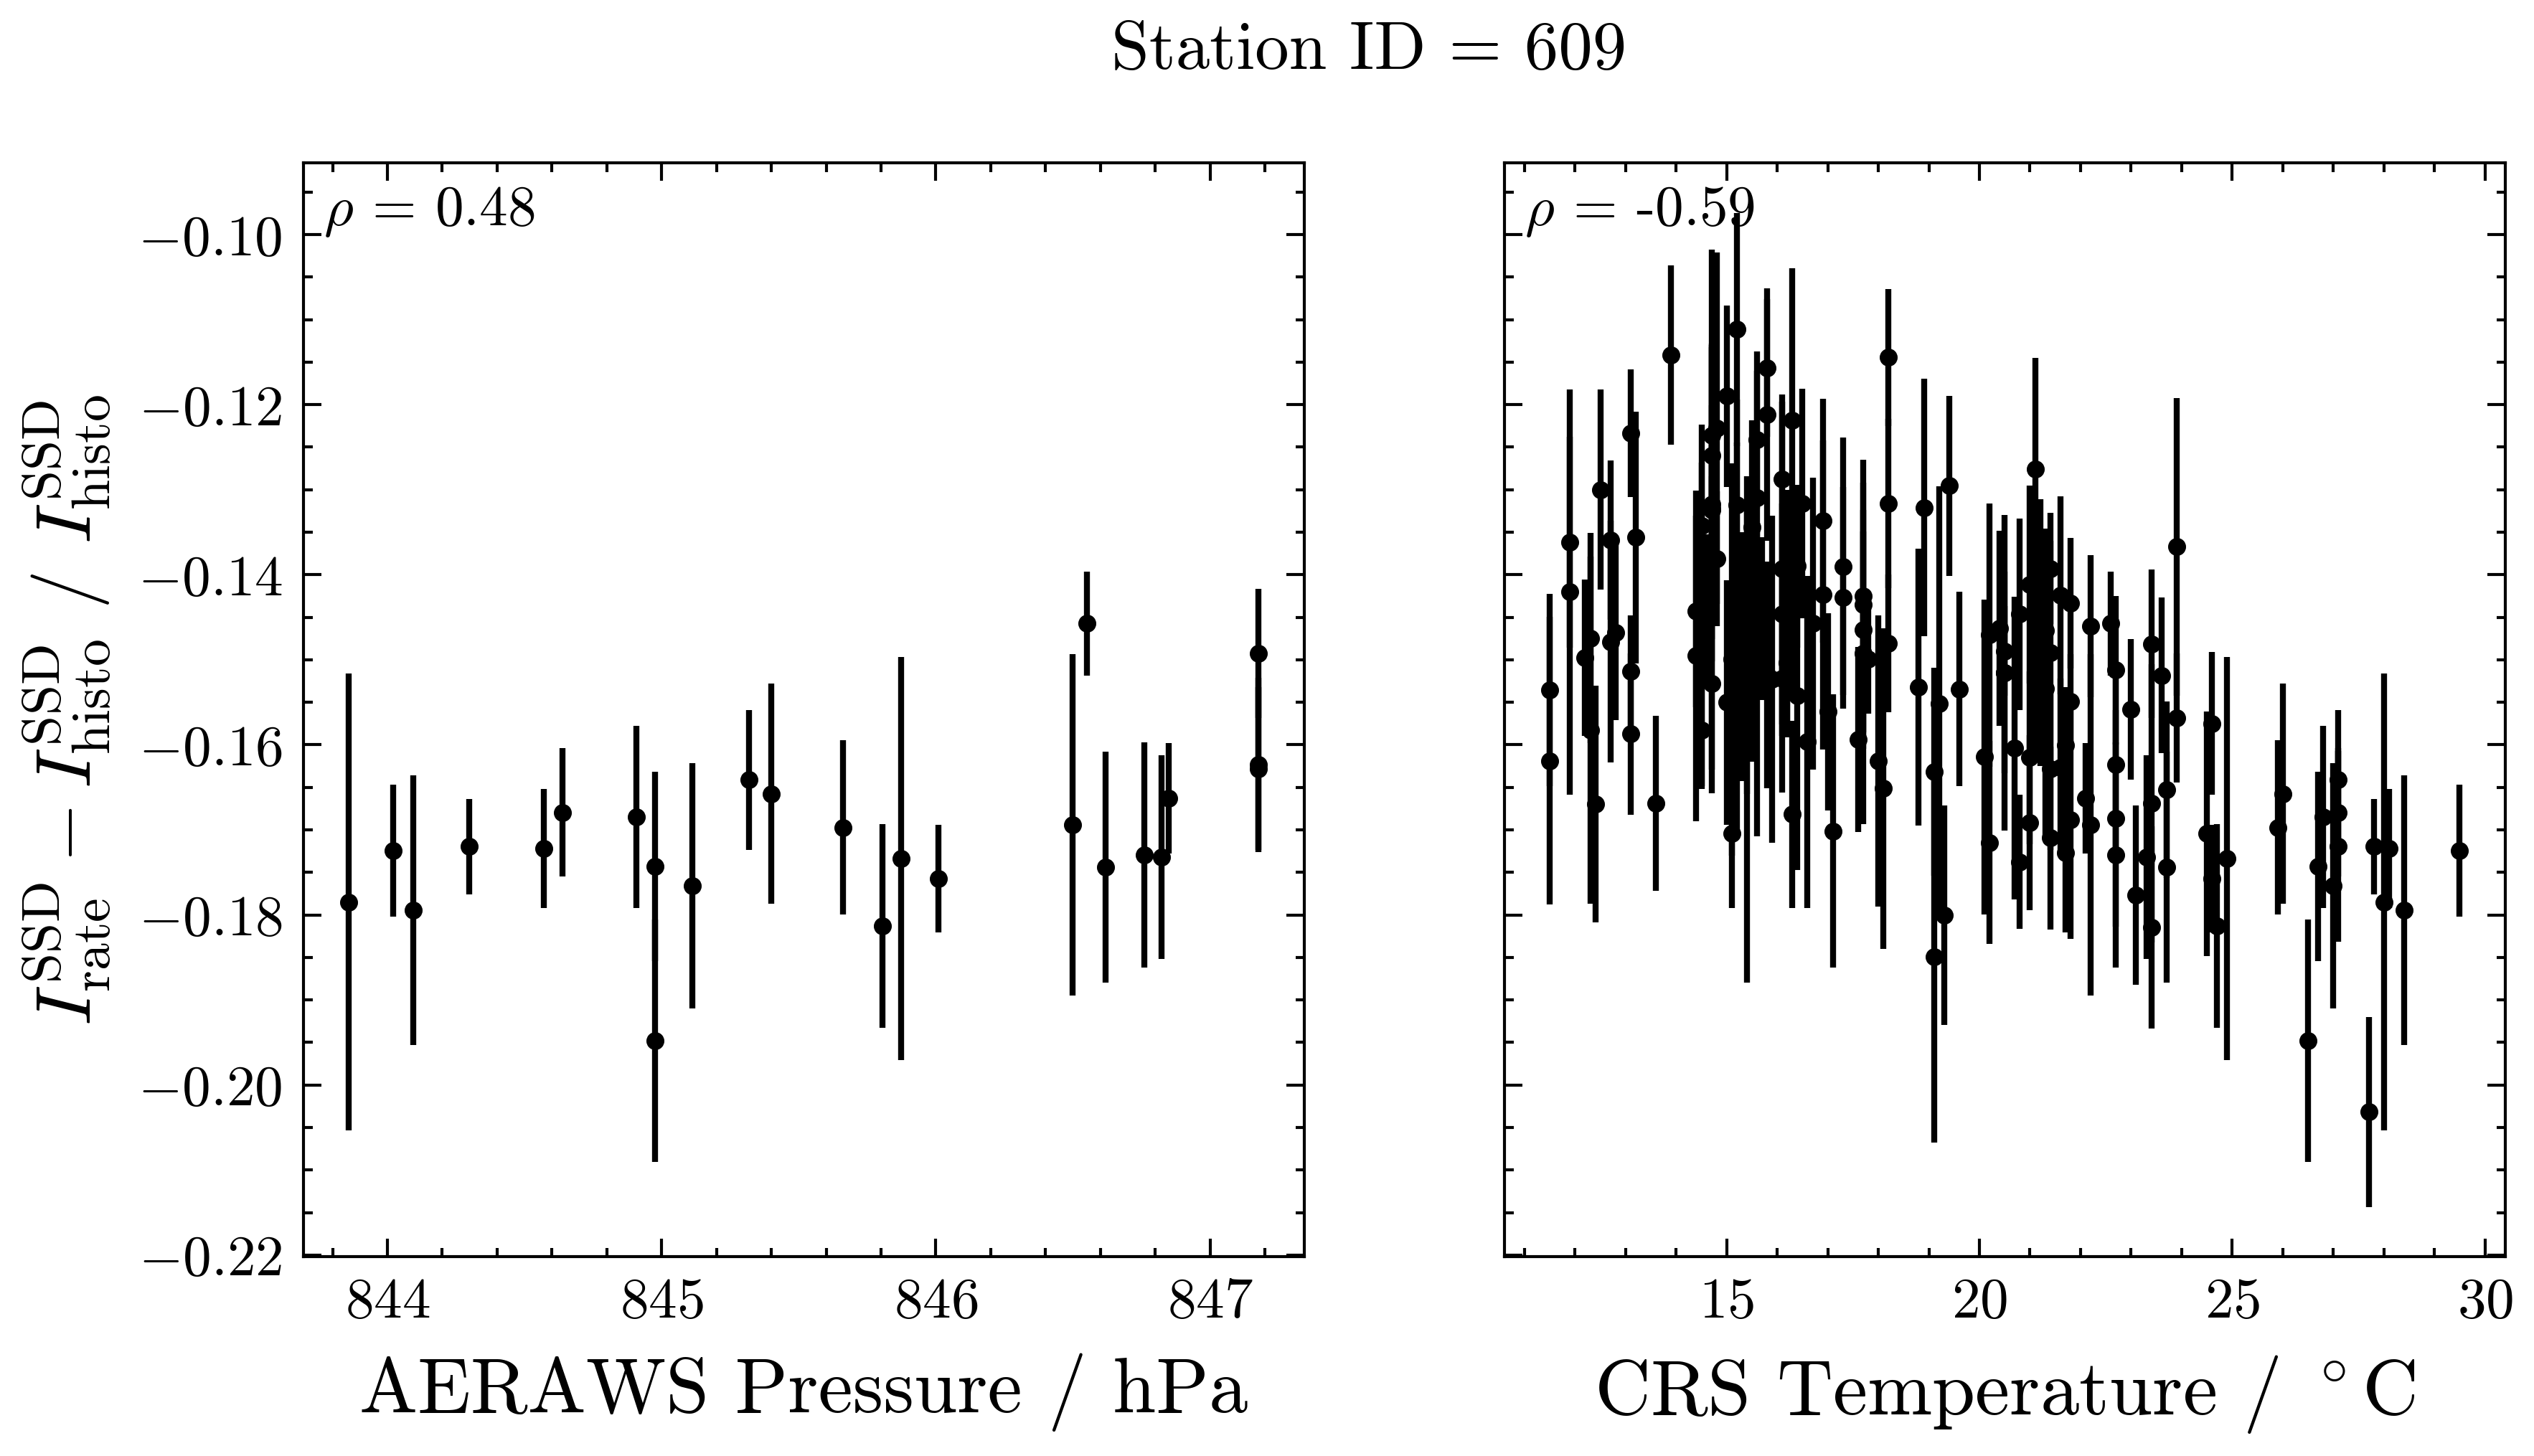

In [38]:
make_plot() # 609

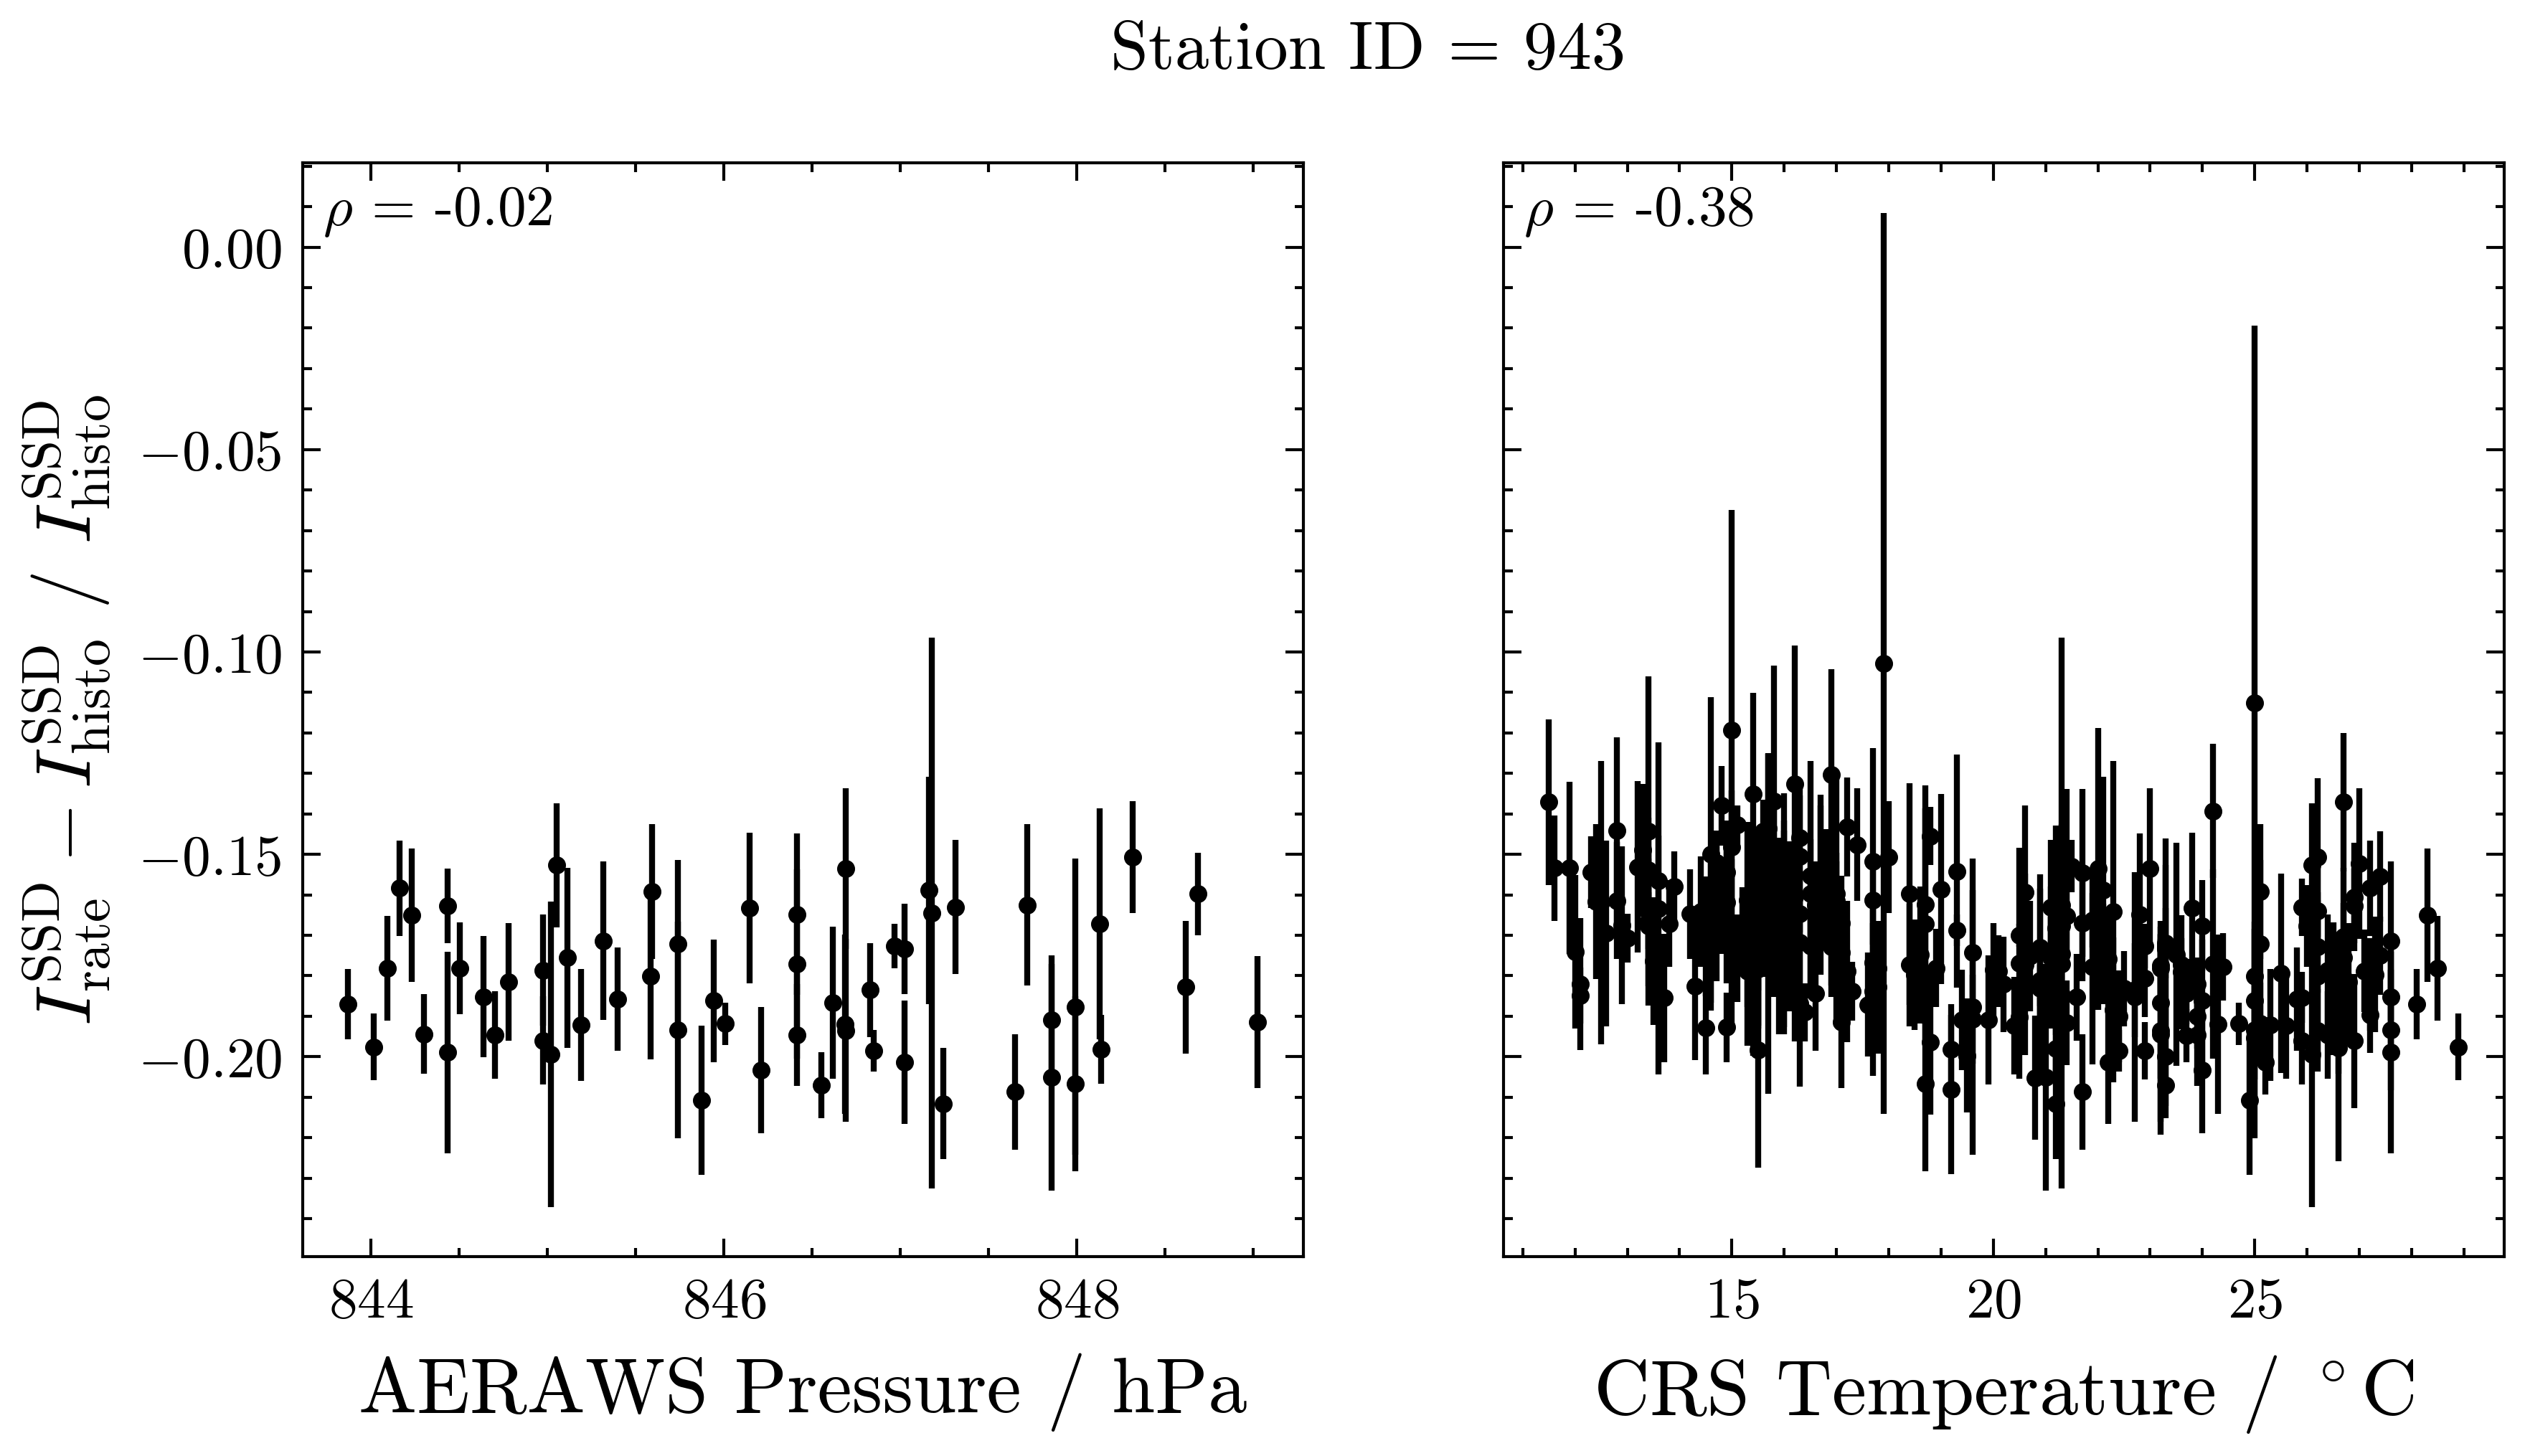

In [40]:
make_plot() # 943

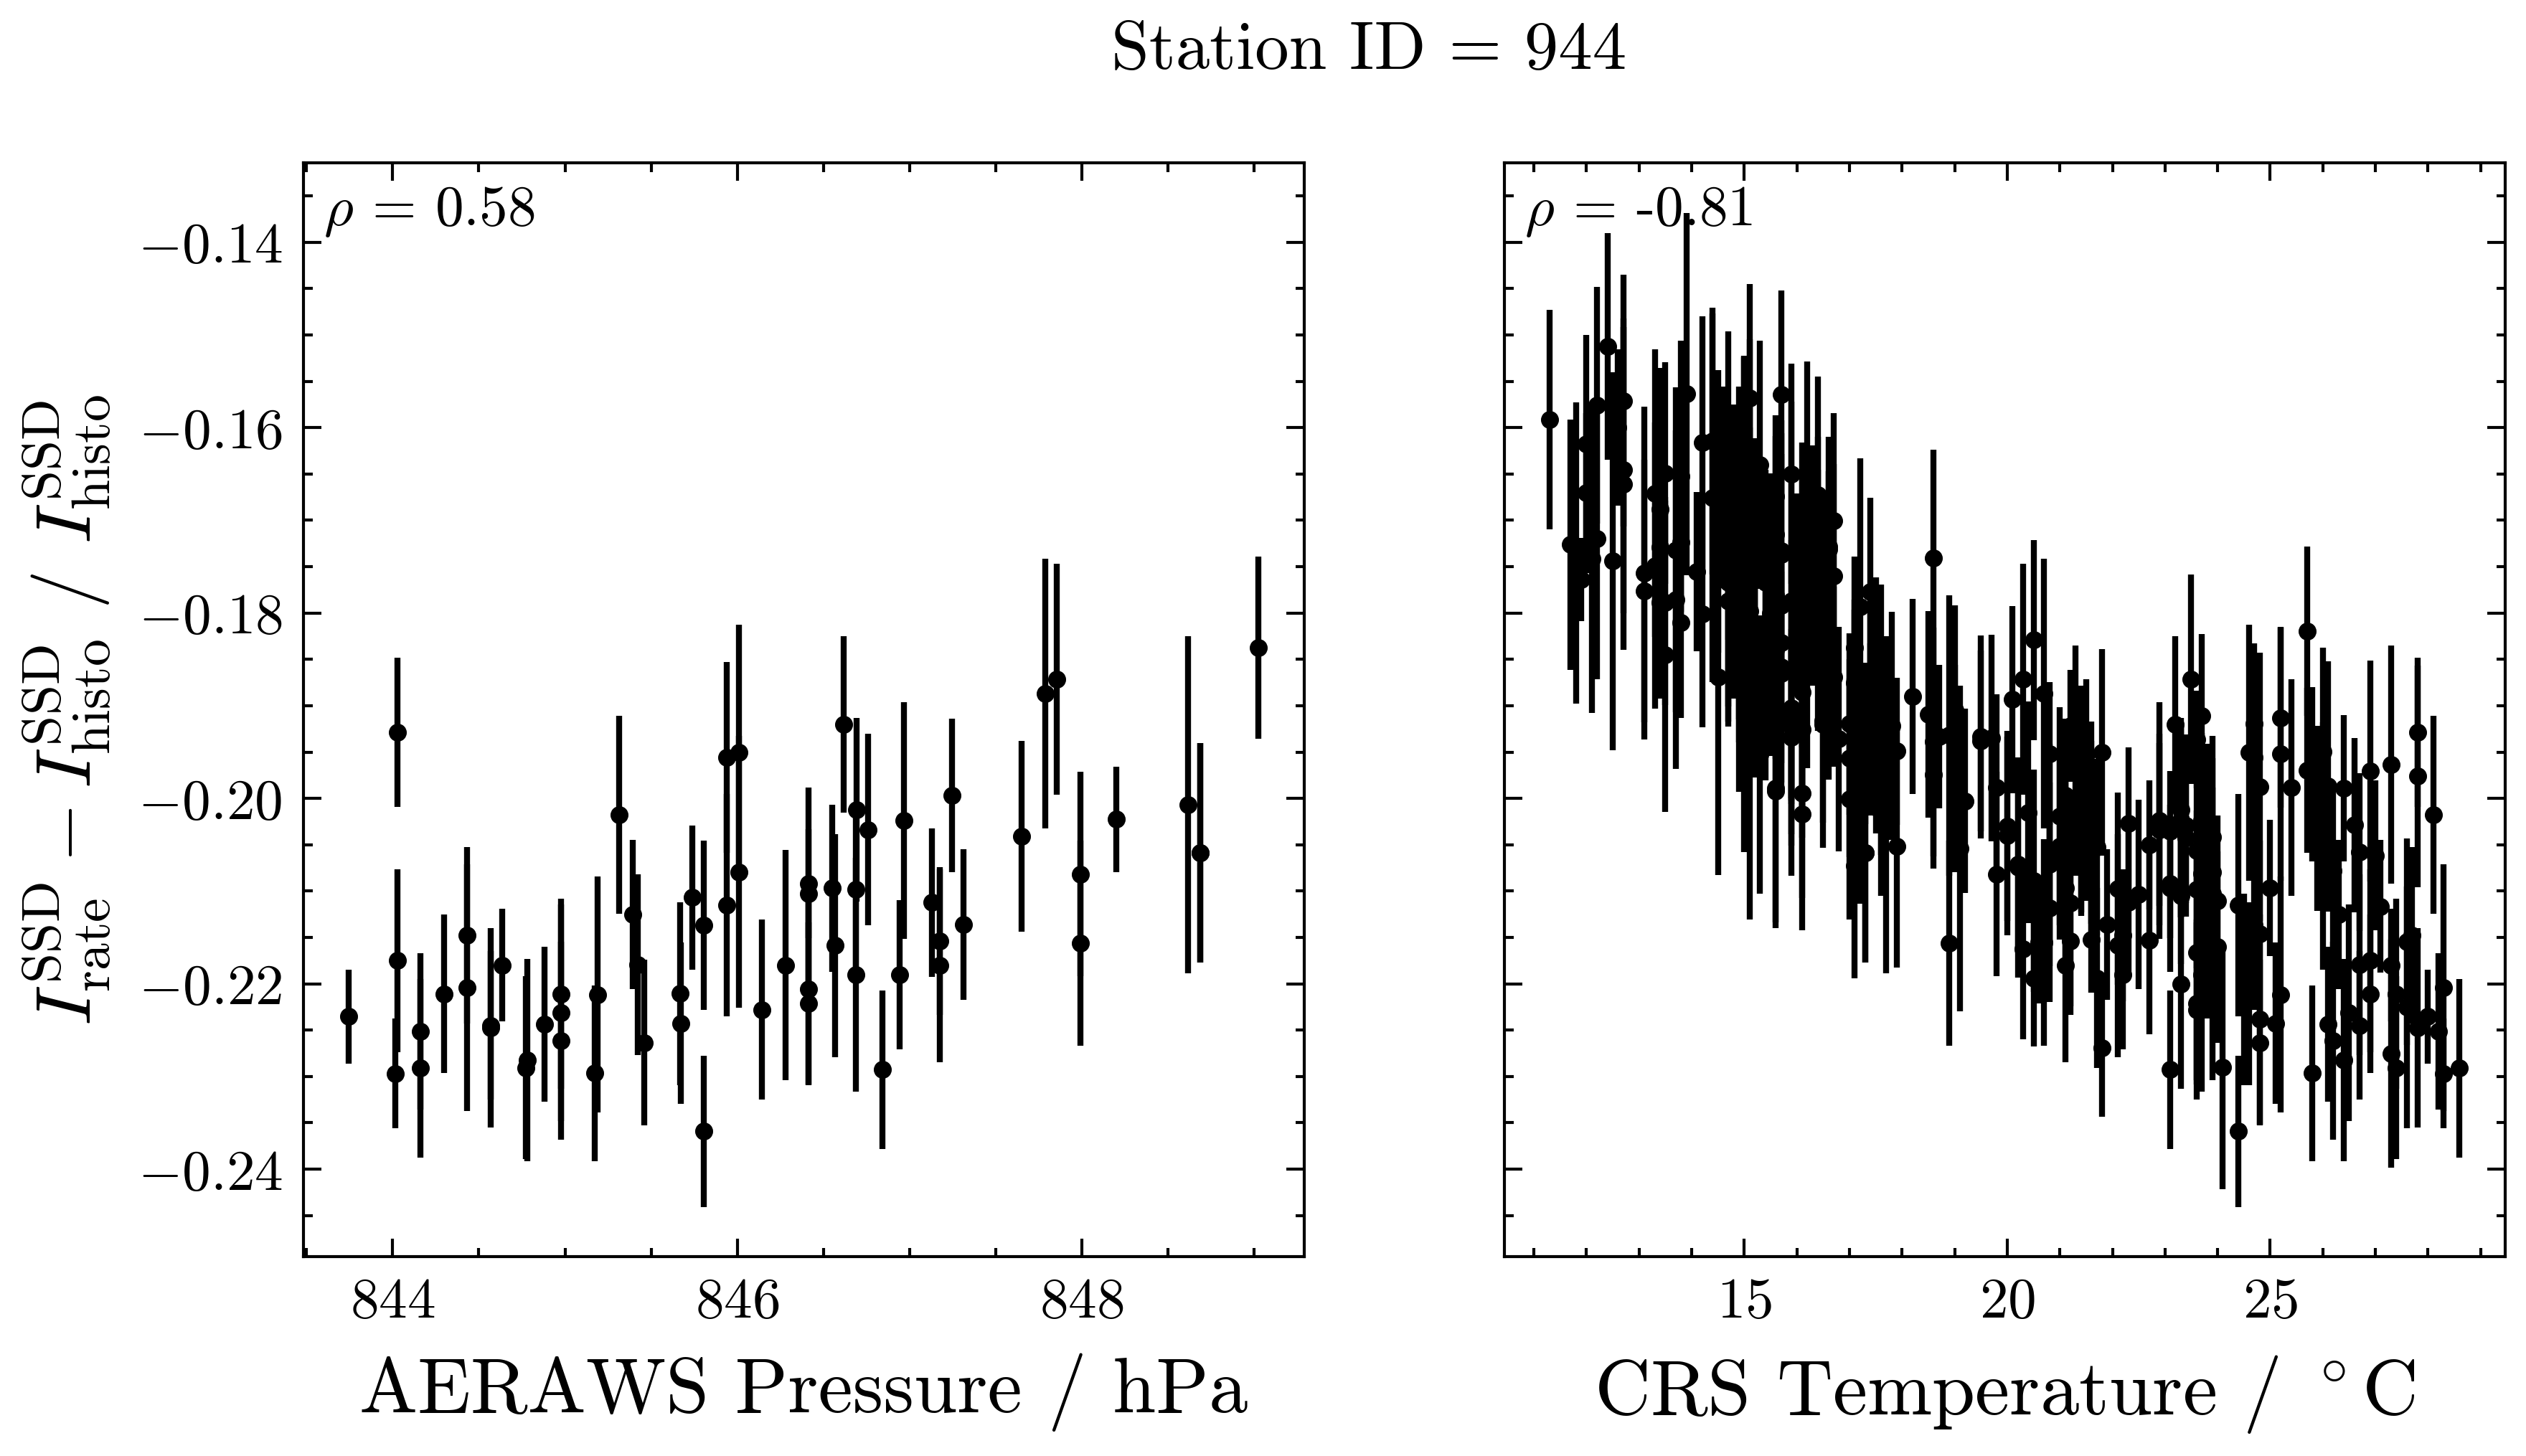

In [42]:
make_plot() # 944

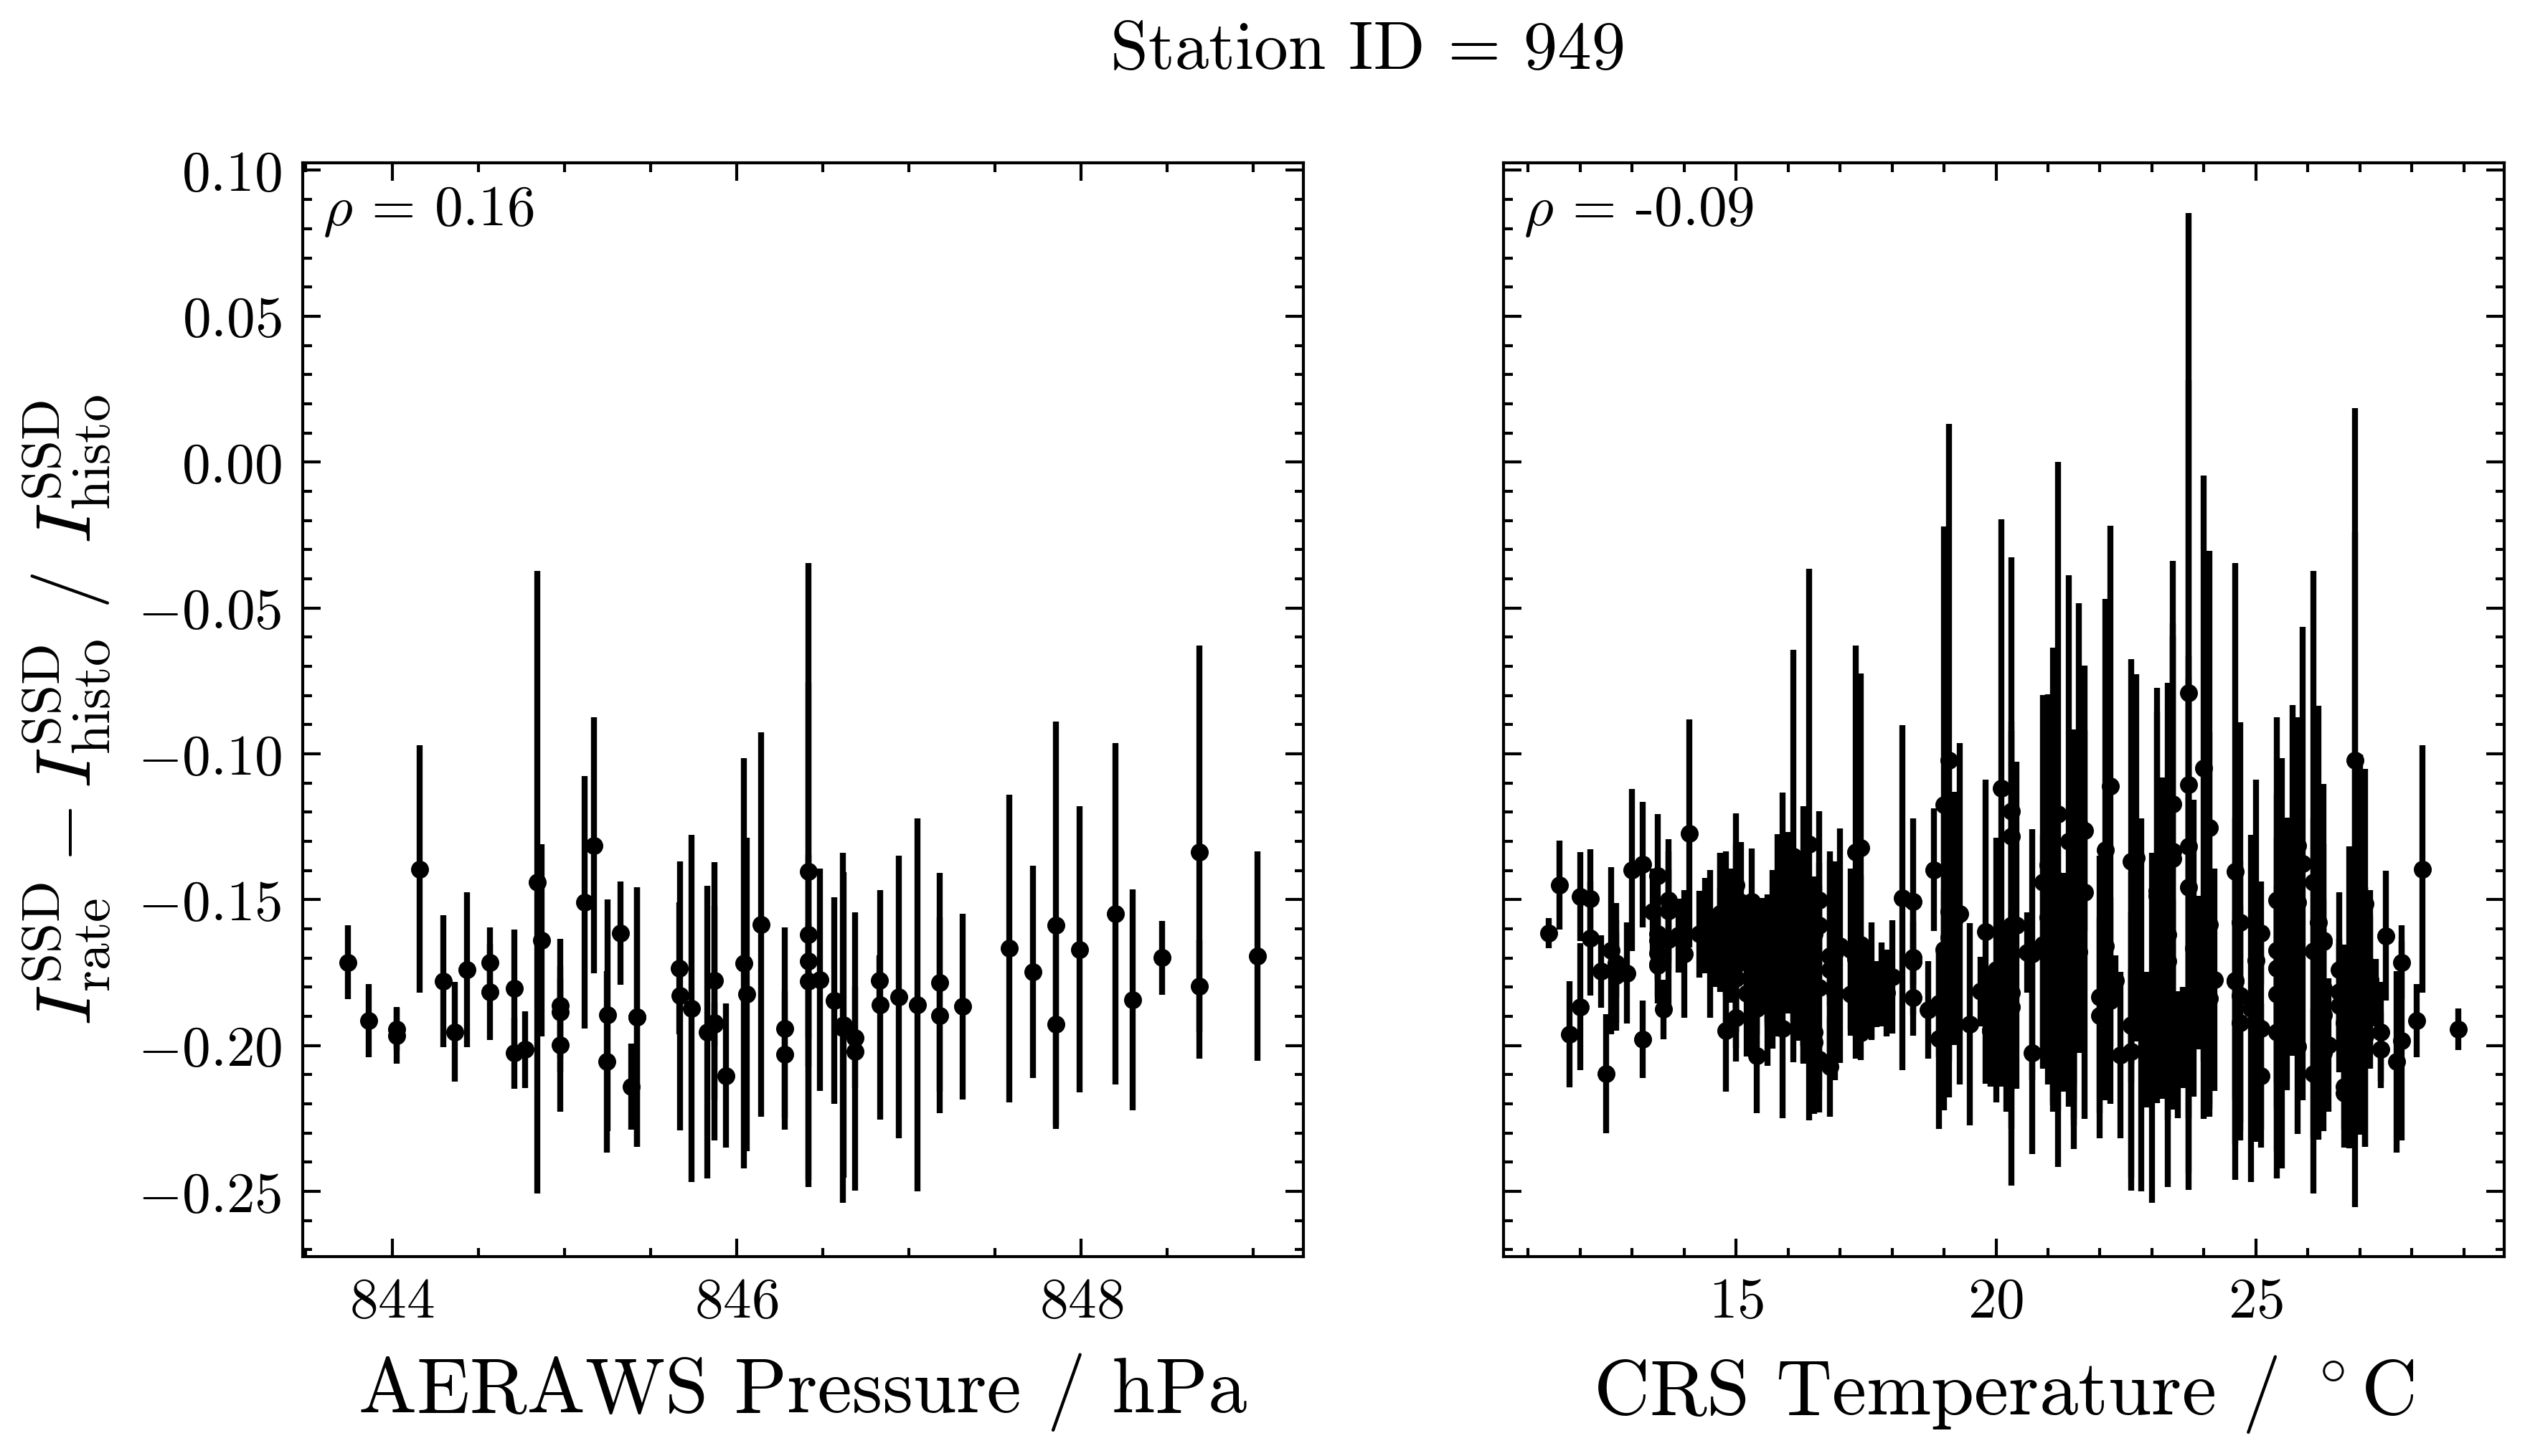

In [44]:
make_plot() # 949

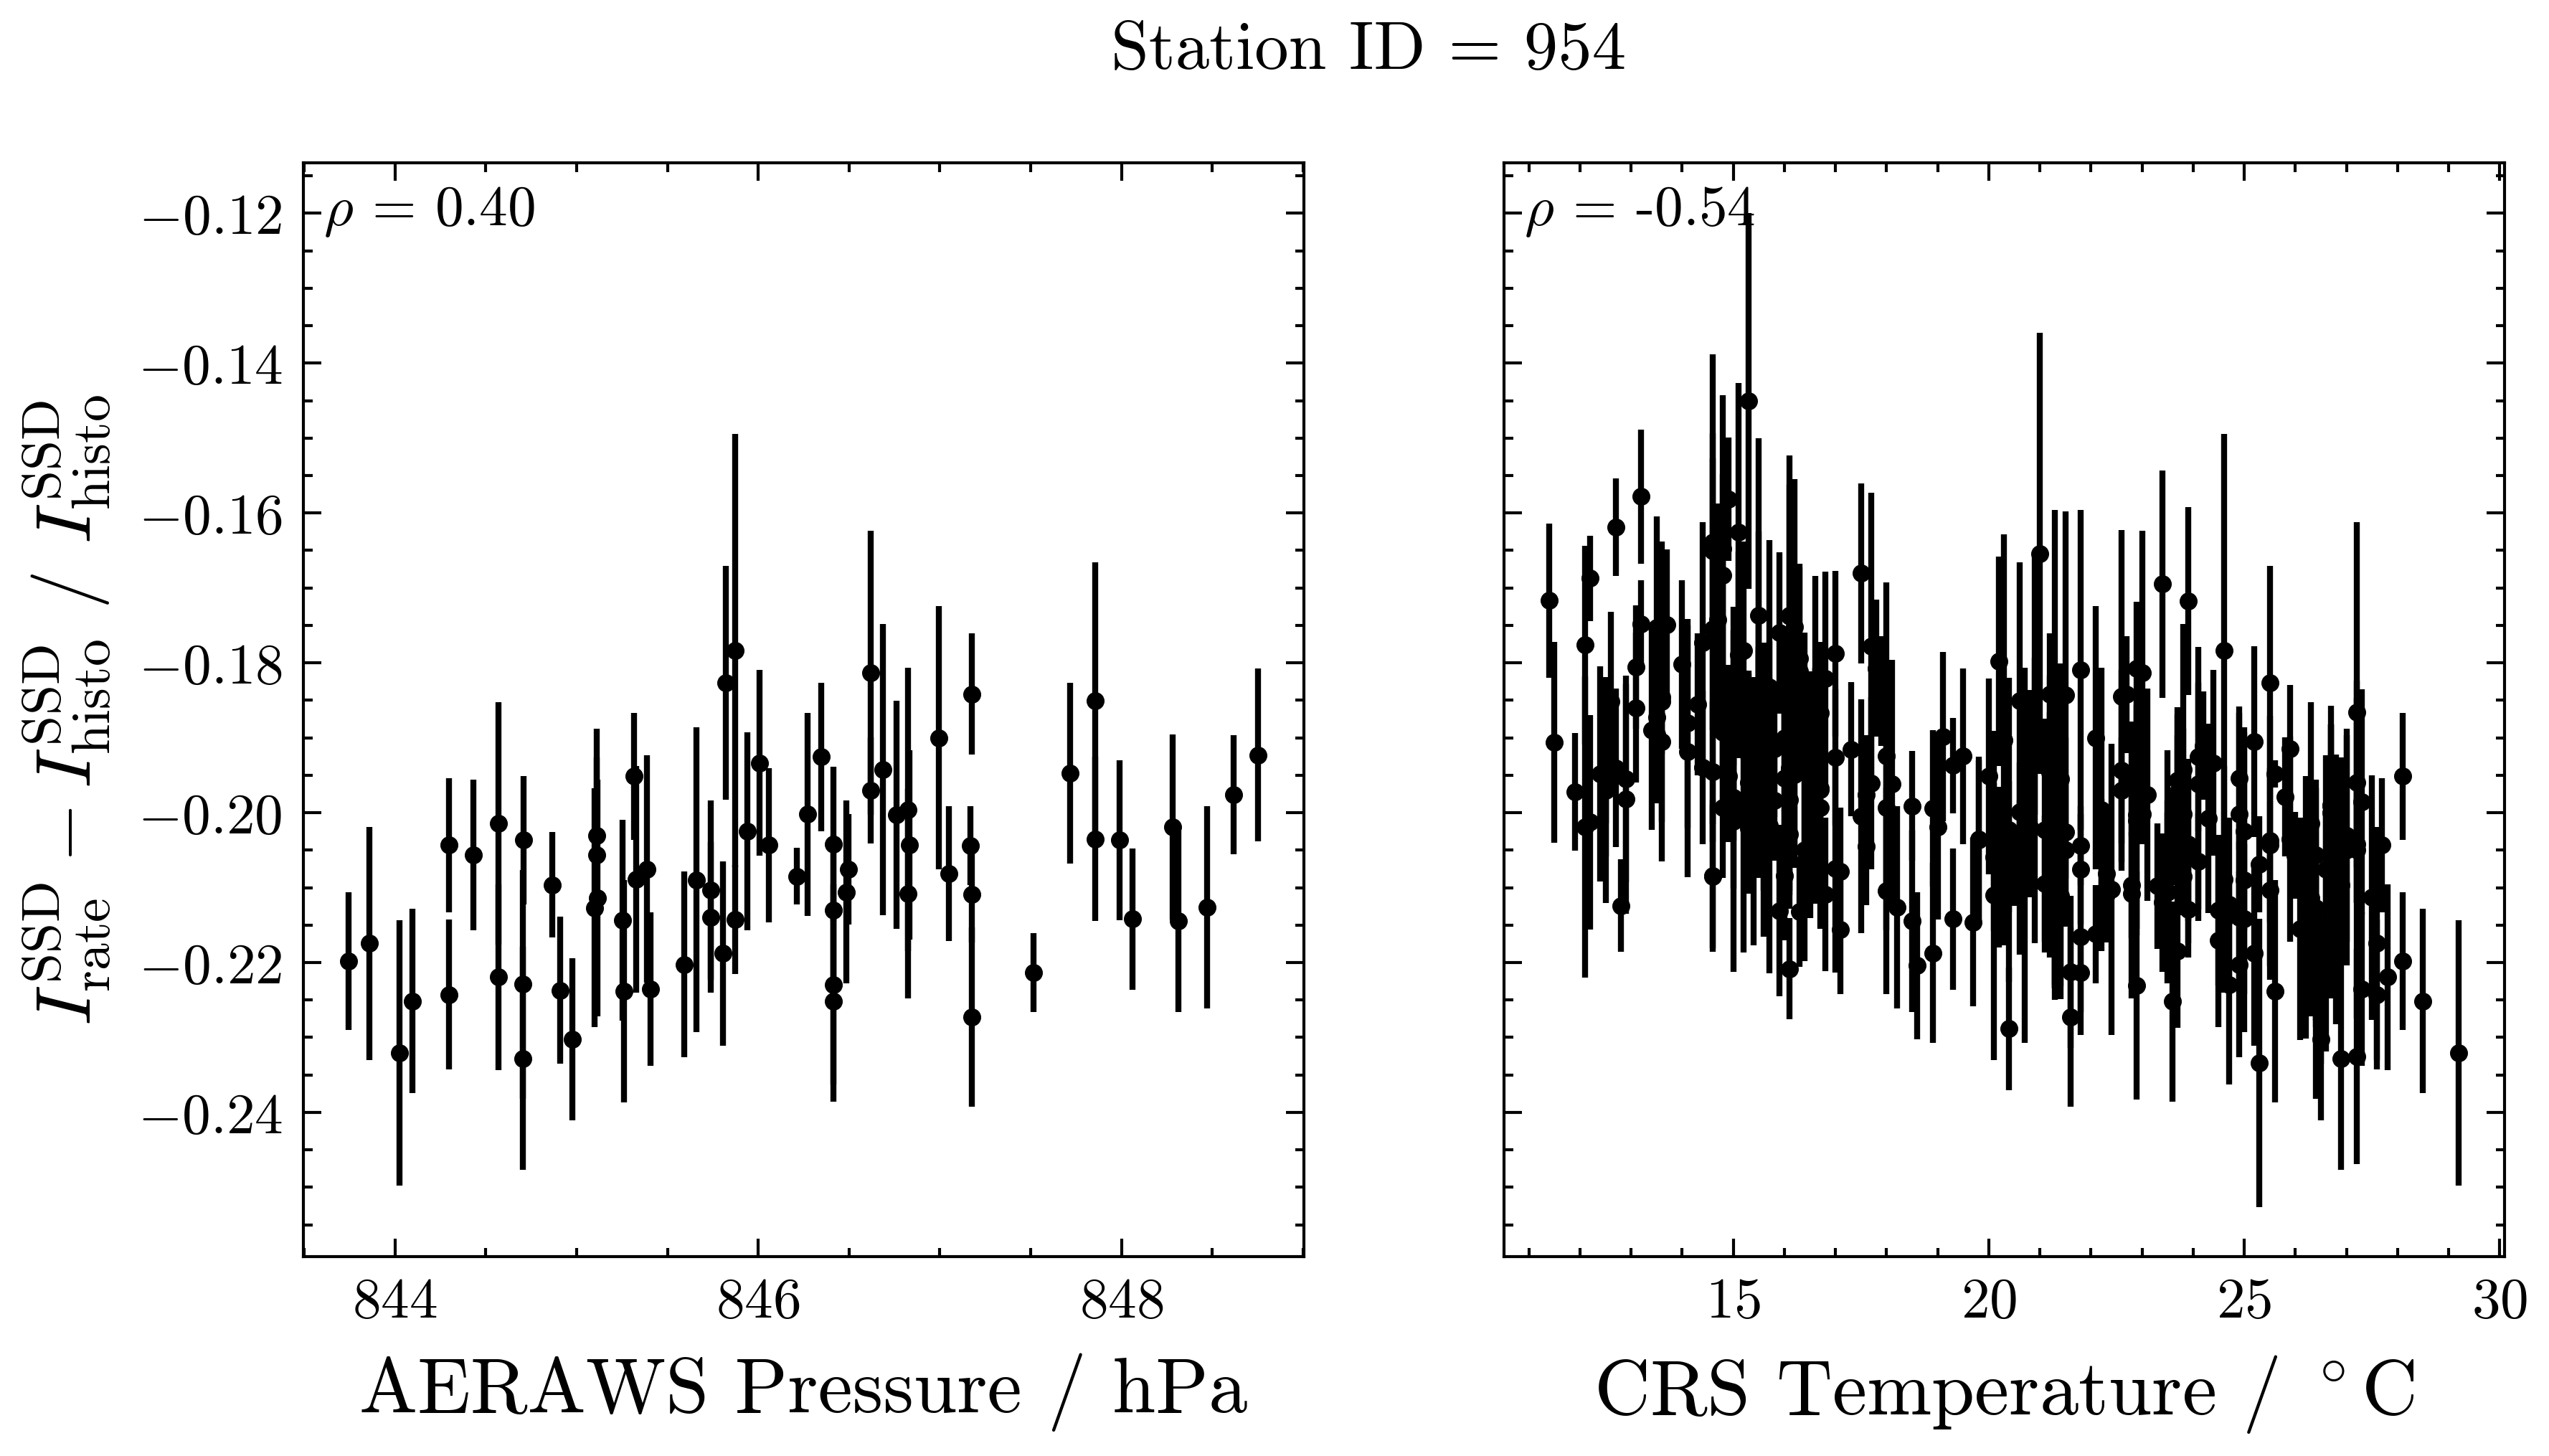

In [46]:
make_plot() # 954